<a href="https://colab.research.google.com/github/ZvikaSinkevich/NLP-Summary-Project/blob/main/NLP_Summary_Project_%2B_Data_collecting_(CV_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction / Read Me: 

---



### Motivation:
> **Business Task:** Get on the first page of Google (SEO improvement).

> **NLP Task:** Generate a high-quality article on a search term using NLP.

> **How:** Extract articles from the first page on Google, and run an abstractive summary NLP model on them


---



### Pipeline:

* Scrawling the first 9 results on google search.
* Scraping the pages and extracting text.
* Filter the text for only paragraphs.
* Run an analysis of the filtered text.
* Parse the text into chunks (size according to the model's tokenizer).
* Run a summary NLP model.
* Save the results to an HTML file


---




### Challenges & Solutions:
* Collecting Data
  * The scraping method should be robust - Any website has a different scheme/architecture.
    
    **Solution:** I prefer to lose data instead of adding noisy data: I'm extracting only HTML paragraph tags and appending only 15 words sentences (MIN_WORDS_IN_SENTENCE threshold).
* Preprocessing: 
  * Most of the transformers models have a tokenizers max length of 512, but the texts are longer.
      
    **Solution:** I chunked the document to sub-docs. To accomplish robustness to various models, I tuned the MAX_CHUNK hyper-parameter to the tokenizer.model_max_length.

* Evaluation (TODO): 
  * Research about matrics for summary problem
  * Find a method to evaluate the model's output.


---






# 00: Impot 

---



In [1]:
!pip3 install --upgrade ecommercetools --quiet
!pip install prettytable --quiet
!pip install neattext --quiet

from IPython.display import HTML, IFrame
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from datetime import datetime
from ecommercetools import seo
import requests
import re
from bs4 import BeautifulSoup
from bs4.element import Comment
from tqdm import tqdm
import nltk
from neattext.functions import clean_text
import tensorflow as tf
import torch

from nltk.tokenize import sent_tokenize, word_tokenize
from transformers import pipeline
from transformers import (AutoModelForSeq2SeqLM,
                          AutoTokenizer,
                          AutoConfig,
                          AutoModel)

     |████████████████████████████████| 47 kB 1.8 MB/s 
     |████████████████████████████████| 2.9 MB 17.7 MB/s 
     |████████████████████████████████| 584 kB 33.3 MB/s 
     |████████████████████████████████| 9.8 MB 34.2 MB/s 
     |████████████████████████████████| 83 kB 2.3 MB/s 
     |████████████████████████████████| 103 kB 45.6 MB/s 
     |████████████████████████████████| 127 kB 44.4 MB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
     |████████████████████████████████| 895 kB 28.0 MB/s 
     |████████████████████████████████| 3.3 MB 26.9 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 114 kB 5.4 MB/s 


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

# 01: Hyper Parameters

---



In [3]:
# Pre processing parameters
search_term = "kartra vs kajabi"


# Transformers parameters
checkpoint = "facebook/bart-large-xsum" # [t5-base google/pegasus-xsum, facebook/wmt19-en-ru, distilbart-xsum-12-1]
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

framework = "pt"
device = 0
save_model = False
summarizer_max_length = int(tokenizer.model_max_length/2)
summarizer_min_length = 100

MAX_CHUNK = int(tokenizer.model_max_length - 300)
MIN_WORDS_IN_SENTENCE = 15

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

# 02: Get First Page links from Google Search
---

In [4]:
google_search_results = seo.get_serps(search_term)
google_search_results.link

0                       https://home.kartra.com/kajabi
1           https://todaytesting.com/kartra-vs-kajabi/
2              https://bloggingx.com/kartra-vs-kajabi/
3                https://codeless.co/kartra-vs-kajabi/
4    https://www.learningrevolution.net/kartra-vs-k...
5        https://athemes.com/reviews/kartra-vs-kajabi/
6    https://thedigitalmerchant.com/ecommerce/kartr...
7    https://www.digitalmarketing.org/blog/kartra-v...
8           https://khrisdigital.com/kartra-vs-kajabi/
9       https://sellcoursesonline.com/kajabi-vs-kartra
Name: link, dtype: object

# 03: Scrawling + Scraping + Pre processing

---



In [5]:
def split_to_chunks(inp_str, max_chunk=500):
    
    # Split to sentences:
    sentences = []
    inp_str = inp_str.replace('.', '.<eos>')
    inp_str = inp_str.replace('?', '?<eos>')
    inp_str = inp_str.replace('!', '!<eos>')
    sentences_unfiltered = inp_str.split('<eos>')

    # Delete short sentences from content tables
    for sen in sentences_unfiltered:
        if len(sen.split(' ')) > MIN_WORDS_IN_SENTENCE:
            sentences.append(sen)

    # Split to chunks:
    current_chunk = 0
    chunks = []

    for sentence in sentences:
        if len(chunks) == current_chunk + 1:
            if len(chunks[current_chunk]) + len(sentence.split(' ')) <= max_chunk:
                chunks[current_chunk].extend(sentence.split(' '))
            else:
                current_chunk += 1
                chunks.append(sentence.split(' '))
        else:
            chunks.append(sentence.split(' '))

    for chunk_id in range(len(chunks)):
        chunks[chunk_id] = ' '.join(chunks[chunk_id])
    return chunks, sentences


urls = []
soup_htmls = {}
corpus = {}
corpus_chunked = {}
sentences = {}

for index, url in enumerate(google_search_results.link):
    urls.append(url)

    # Open the URL:
    webpage = requests.get(url)

    # Parse to HTML:
    doc = BeautifulSoup(webpage.text, "html.parser")  # "html.parser" html5lib

    # Get only the text on the doc:
    text = doc.findAll("p", text=True)

    # clean the text:
    soup_htmls[index] = doc
    filtered_text = u" ".join(t.get_text(strip=True) for t in text)

    cleaned_text = clean_text(filtered_text,
                              emojis=True,
                              phone_num=True,
                              urls=True,
                              emails=True,
                              multiple_whitespaces=True)

    # Split long texts to chunks of 500 words:
    if len(filtered_text) > 500:
        corpus[index] = filtered_text
        corpus_chunked[index], sentences[index] = split_to_chunks(corpus[index], 
                                                                  MAX_CHUNK)

# 04: EDA

---



### Visualization - WordCloud view

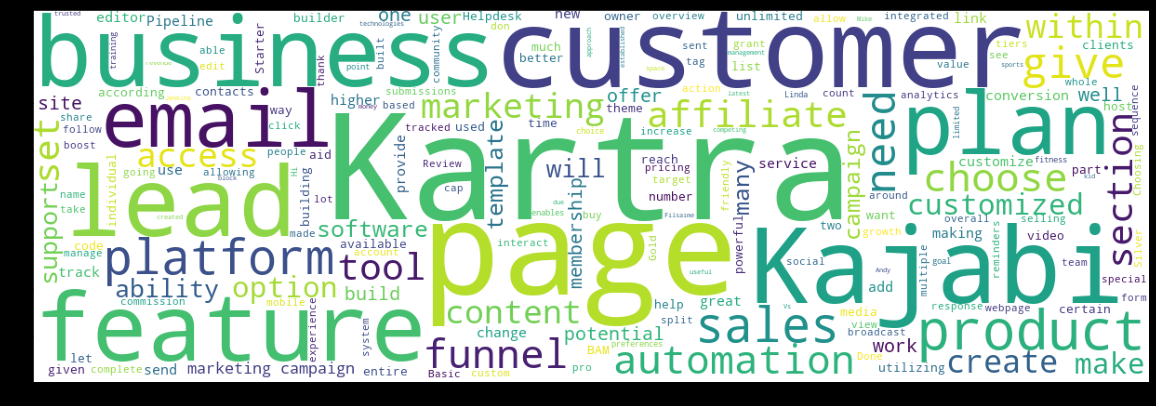

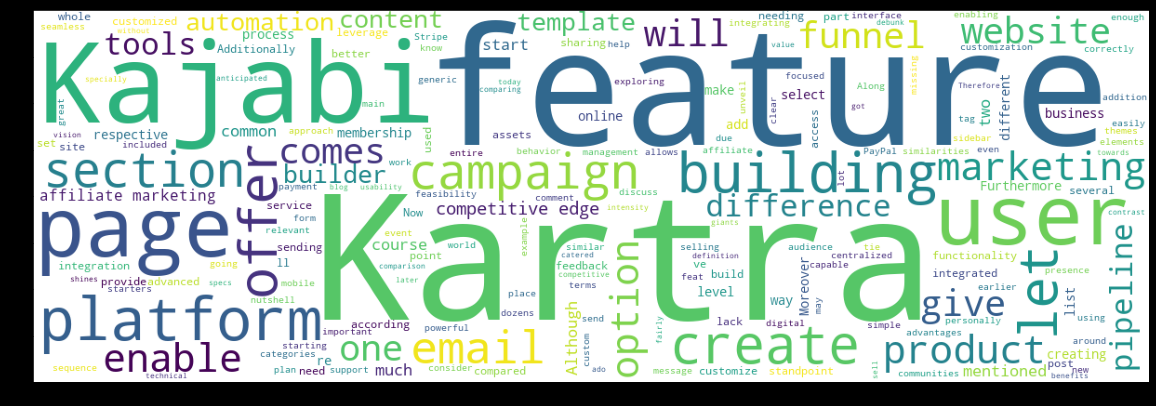

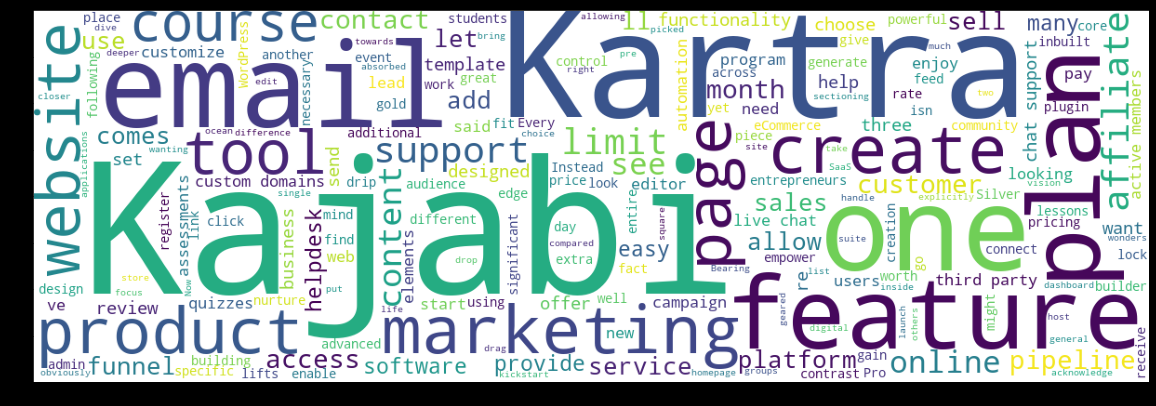

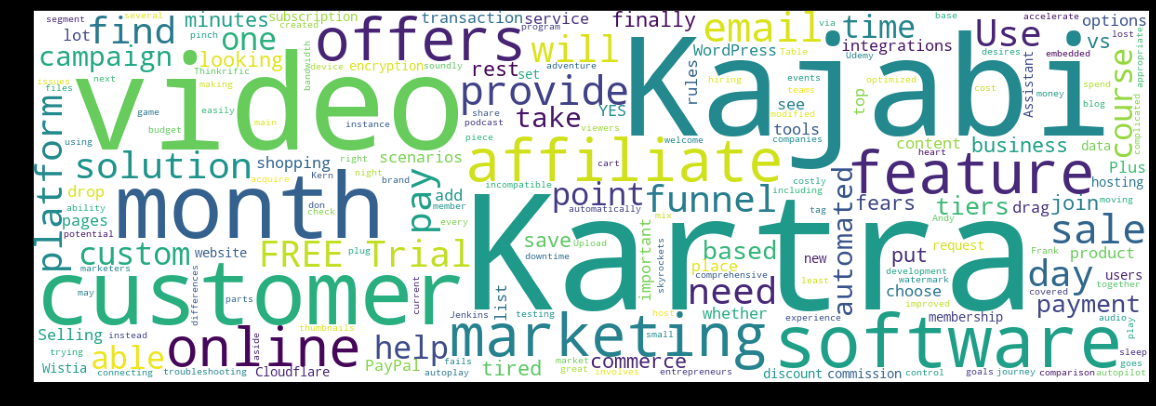

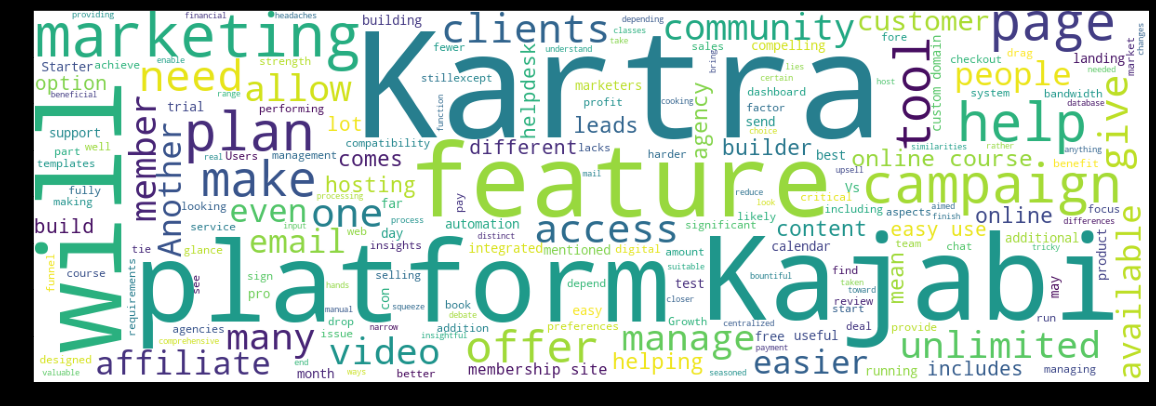

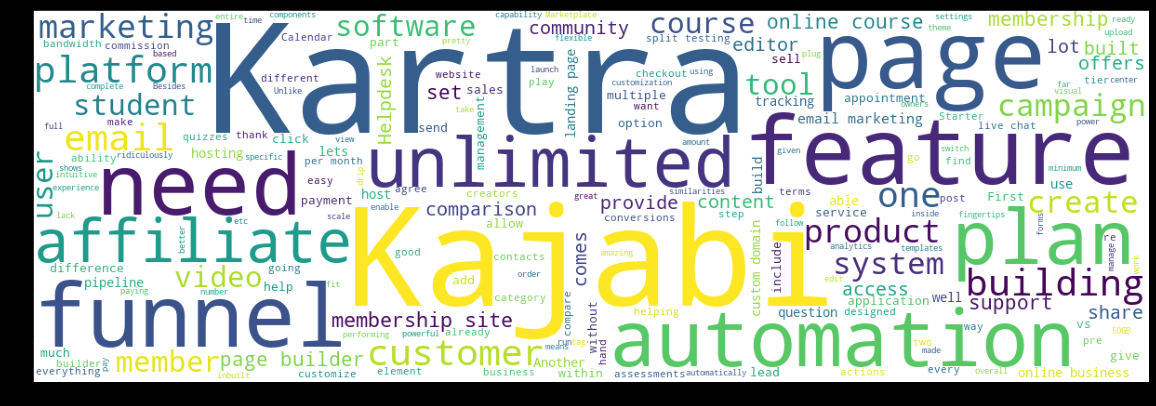

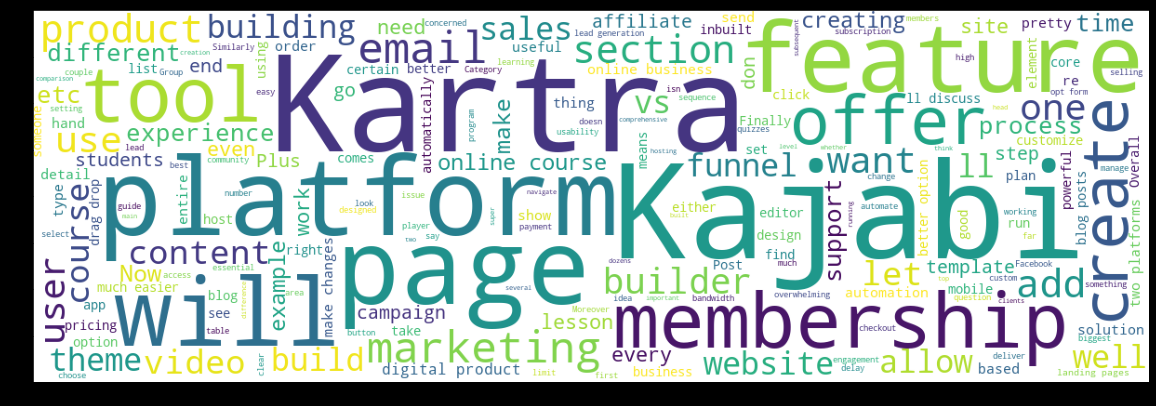

In [6]:
for i in corpus_chunked.keys():
  wordcloud = WordCloud(background_color="white",
                        width=1200, 
                        height=400).generate(' '.join(corpus_chunked[i]))
  plt.figure( figsize=(20,10), facecolor='k')
  plt.imshow(wordcloud)

### NLTK (For Statistics)

In [7]:
nltk.download('punkt')

tokens_sentences = {}
tokens_words = {}
t = PrettyTable(['Link', 'Sentences', 'Words', 'Letters'])

for index in corpus_chunked.keys():
    t.add_row([google_search_results.link[index], '-', '-', '-'])
    for i in range(len(corpus_chunked[index])):
        tokens_sentences[index] = sent_tokenize(corpus_chunked[index][i])
        tokens_words[index] = word_tokenize(corpus_chunked[index][i])
        t.add_row([index,
                  len(tokens_sentences[index]),
                  len(tokens_words[index]),
                  len(corpus_chunked[index][i])])
print(t)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
+------------------------------------------------------------+-----------+-------+---------+
|                            Link                            | Sentences | Words | Letters |
+------------------------------------------------------------+-----------+-------+---------+
|         https://todaytesting.com/kartra-vs-kajabi/         |     -     |   -   |    -    |
|                             1                              |     30    |  758  |   4032  |
|                             1                              |     28    |  730  |   4040  |
|                             1                              |     33    |  743  |   3983  |
|           https://codeless.co/kartra-vs-kajabi/            |     -     |   -   |    -    |
|                             3                              |     28    |  799  |   4278  |
|                             3                          

# 05: Model (Transformers)

---



### Run Tokenizer & Model


In [8]:


# [sshleifer/distilbart-12-3-cnn ,
#  sshleifer/distilbart-cnn-12-6 ,
#  sshleifer/distilbart-xsum-12-1 , 
#  patrickvonplaten/longformer2roberta-cnn_dailymail-fp16]

# from transformers import EncoderDecoderModel

# checkpoint = "t5-base"

# model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Save the model:
if save_model:
    model.save_pretrained('my_model' + search_term)

# Define pipelines
summarizer = pipeline("summarization",
                      model=model,
                      tokenizer=tokenizer,
                      framework=framework,
                      device=device)

# Run Summarize on each search result
summarizer_results = {}
for index in tqdm(corpus_chunked.keys()):
    summarizer_results[index] = summarizer(corpus_chunked[index],
                                           max_length=summarizer_max_length,
                                           min_length=summarizer_min_length,
                                           do_sample=False)


  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 7/7 [01:51<00:00, 15.89s/it]


### Save Results to HTML

In [9]:

output_table = pd.DataFrame()

# Add the hyper parameters to output
output_table = output_table.append([f'search_term: {search_term}',
                                    f'checkpoint: {checkpoint}',
                                    f'framework: {framework}',
                                    f'device: {device}',
                                    f'summarizer_max_length: {summarizer_max_length}',
                                    f'summarizer_min_length: {summarizer_min_length}',
                                    f'MAX_CHUNK: {MAX_CHUNK}',
                                    f'MIN_WORDS_IN_SENTENCE: {MIN_WORDS_IN_SENTENCE}'],
                                    ignore_index=True)

# Save the summarizers input/output to a Dataframe
for i in corpus_chunked.keys():

    # Add the link of the website
    output_table = output_table.append([google_search_results.link[i]],
                                       ignore_index=True)

    # Add the document chunks (beforw summary), 
    # and the summary results (for each chunk):
    summarizer_io = pd.concat([pd.DataFrame(corpus_chunked[i]),
                               pd.DataFrame(summarizer_results[i])],
                              axis=1)
    
    output_table = pd.concat([output_table, summarizer_io])

output_table.columns = ['original_text', 'summary_text']

# Save to HTML
output_table.to_html('output.html',
                     render_links=True,
                     justify='center')



### Concat to one aritcle

In [10]:
output = {}

for index in summarizer_results.keys():
    output[index] = ' '.join([summ['summary_text'] for summ in summarizer_results[index]])

In [11]:
index = list(summarizer_results.keys())

In [12]:
output[index[-1]]

'In our series of reviews, we’re going to look at two of the most popular online business platforms in India and ask whether they are a better option for your online business, especially if you want to create and deliver digital products like online courses, memberships, websites and marketing funnels, or whether there is another platform that is better for your needs, and which one should you choose?    I’ve been working with two of these platforms for the past few years and they are both very good. If you want to create an online course or membership in Kajabi, you first need to create a “Product” which is the part of your digital product where your students will watch your videos and then add content to it and then upload them to your membership site in the form of lessons, modules, quizzes, surveys, assignments, and other pieces of content that you’ve created for your course and/or membership in your online course/membership site on the platform. If you’re looking for a platform to

In [13]:
corpus[index[-1]]

'Kajabi and Kartra are two of the most popular online business platforms and they stand out in this crowded market with their promise of being all-in-one solutions. So, I decided to use my experience of working with dozens of clients on these platforms and create the most comprehensive Kartra vs Kajabi guide. In this review, we will go into details of every feature these platforms offer for running an online business, especially a digital products business, and based on them, do a head-to-head comparison. By the end, you’ll have a clear idea of whether either of these platforms will work for you or not and if yes, which one of the two will be a better option. The main difference between the two platforms is that Kajabi at its core is an online course platform that also offers tools for building a website and marketing funnels while Kartra, on the other hand, is primarily a marketing platform that also offers features for hosting and delivering online courses and memberships. What I lik

In [14]:
summarizer_results[index[-1]]

[{'summary_text': 'In our series of reviews, we’re going to look at two of the most popular online business platforms in India and ask whether they are a better option for your online business, especially if you want to create and deliver digital products like online courses, memberships, websites and marketing funnels, or whether there is another platform that is better for your needs, and which one should you choose?    I’ve been working with two of these platforms for the past few years and they are both very good.'},
 {'summary_text': 'If you want to create an online course or membership in Kajabi, you first need to create a “Product” which is the part of your digital product where your students will watch your videos and then add content to it and then upload them to your membership site in the form of lessons, modules, quizzes, surveys, assignments, and other pieces of content that you’ve created for your course and/or membership in your online course/membership site on the platf

# 06: Results

---


In [15]:
# output_table.style.highlight_null(null_color="green")
# output_table.reset_index(inplace=True)
# output_tabledf.head(5).style.app

output_table.to_html('output.html',
                     render_links=True,
                     justify='center')

In [16]:
HTML(filename='/content/output.html')

,original_text,summary_text
0,search_term: kartra vs kajabi,NaN
1,checkpoint: facebook/bart-large-xsum,NaN
2,framework: pt,NaN
3,device: 0,NaN
4,summarizer_max_length: 512,NaN
5,summarizer_min_length: 100,NaN
6,MAX_CHUNK: 724,NaN
7,MIN_WORDS_IN_SENTENCE: 15,NaN
8,https://todaytesting.com/kartra-vs-kajabi/,NaN
9,"Kartra and Kajabi are competing marketing and business management tools that give you access to the latest technologies that can boost your customer reach and your revenue. Kartra is the new kid on the block and is making a name for itself in the software marketing space due to its value for money approach and the useful features it sports. Kajabi has been around for some time and has established itself as a trusted platform with many users utilizing the software for their business needs. Kartra Vs Kajabi 2020 Review Kartra was created in 2018 by Andy Jenkins and Mike Filsaime, both accomplished marketers. The software has made a big splash in the market because of its many features and affordable pricing. Kajabi is the more seasoned platform and was started in 2010 by co-founder and CEO Kenny Reuter. With more than 600 million dollars in online sales and an estimated 20,000 businesses utilizing its tools, the company has an impressive CV. Both platforms provide a drag and drop style page builder removing the need to know code or hire a web developer. Kartra offers over 500 customizable page and section templates to choose from including lead capture pages, sales pages, checkout pages and a lot more. All the pages are mobile and tablet responsive and are integrated with Kartra’s other tools like analytics and split testing. The page editor works with a column and a component mode allowing you to change entire sections or the content within the sections. Kajabi lets you create standalone pages or a Pipeline (a funnel) and has many templates like lead pages, sales pages, and home pages. Building a webpage in Kajabi has been split into 2 parts- the page builder and the theme editor. In the page builder, you are given the option to choose a template and then edit the title, URL, visibility and SEO settings. You are also able to edit the code (only available on the pro plan) should you have the necessary skills. The theme editor gives you the freedom to completely customize your page-change the font size and color, add sections, view the mobile responsiveness, add social media links and much more. An effective email marketing campaign can make customers and potential customers aware of what you are selling and can aid in building confidence in your business. The idea is to target your customer’s wants and needs making them more likely to open the emails you send and act on the product or service you are selling. Automations can be set up based on whether a customer has opened an email, clicked on a link, subscribed to a list, or purchased a certain product. A count-down timer feature that encourages customers to buy or sign up for special offers has also been included. The higher pricing tiers allow for a larger number of emails: Silver-125,000, Gold-250,000, and Platinum-500,000. Kajabi’s email service has a host of features to help you manage your email lists and customize your campaigns. Broadcasts can be sent out to your entire mailing list or you can segment your customers so that only certain groups receive certain emails. Emails can easily be customized with calls to action and buttons and you have the ability to personalize the messages sent out. Membership sites are a great way to deliver content and services to your clients, both platforms give you the option to build your own. You are given two membership sites to work with on the starter plan, while on the upgraded plans you have access to unlimited sites. Login pages, usernames, and passwords are automatically generated to add to the ease of use. There is a range of product themes to choose from to get the look of your site right and if those don’t work for you